# <h1><b><I> General Setup

## Imports and general setup

In [2]:
import os, sys
sys.path.append("gammabayes/dark_matter/")
sys.path.append("gammabayes")

from gammabayes.dark_matter.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.utils.utils import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis, time,psf, edisp, bkgdist, interpolate, special, integrate
from gammabayes.utils.utils import SkyCoord, WcsGeom, inverse_transform_sampling, tqdm#, setup_full_fake_signal_dist_copy_vers#, setup_full_fake_signal_dist, diff_irf_marg
from GammaBayes.gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from GammaBayes.gammabayes.priors.prior import discrete_logprior
from GammaBayes.gammabayes.likelihoods.likelihood import discrete_loglikelihood
from gammabayes.utils.utils import edisp_test, psf_test, log10eaxis, longitudeaxis, latitudeaxis
from gammabayes.utils.utils import psf_efficient, edisp_efficient, edisp_test, psf_test, single_likelihood
from GammaBayes.gammabayes.dark_matter.SS_DM_Prior import SS_DM_dist


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, multiprocessing, yaml
from multiprocessing import Pool, freeze_support
import pandas as pd


from gammabayes.utils.utils import read_config_file


/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("gammabayes/package_data/psfnormalisation.npy")
edispnormalisationvalues = np.load("gammabayes/package_data/edispnormalisation.npy")


In [ ]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(601, 35, 30) (18, 15)


## Script Parameter Setup

In [ ]:
startertimer = time.perf_counter()
print(startertimer)

config_inputs = read_config_file('example_config_file.yaml')

nsig                = int(round(config_inputs['xi']*config_inputs['Nevents']))
nbkg                = int(round((1-config_inputs['xi'])*config_inputs['Nevents']))



3.05074225
file path: example_config_file.yaml


# <h1><b>Simulation

## Setup

### Background setup

In [ ]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacobtrue)

logbkgpriorvalues.shape


nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [ ]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [ ]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(config_inputs['logmass'],), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(-0.1,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7fce427f4dc0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [ ]:
if config_inputs['xi']!=0.0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

In [ ]:

if config_inputs['xi']!=1.0:
    bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)
else:
    bkglogevals = np.asarray([])
    bkglonvals = np.asarray([])
    bkglatvals = np.asarray([])

## Reconstructed Value Simulation

In [ ]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [ ]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1
boop
Axes shape: (151,)


In [ ]:
psf_like = discrete_loglikelihood(logfunction=psf_test, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (18, 15)


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function psf_test at 0x7fce41886d30>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [ ]:

if config_inputs['xi']!=0.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
else:
    signal_log10e_measured = np.asarray([])

  0%|          | 0/800 [00:00<?, ?it/s]

 78%|███████▊  | 622/800 [00:00<00:00, 1566.99it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/../GammaBayes/gammabayes/likelihoods/likelihood.py:79: RuntimeWarning: invalid value encountered in subtract
  loglikevalswithlogjacob = loglikevalswithlogjacob - logsumexp(loglikevalswithlogjacob, axis=(*np.arange(self.axes_dim),))
100%|██████████| 800/800 [00:00<00:00, 1541.23it/s]


In [ ]:

signal_lon_measured = []
signal_lat_measured = []

if config_inputs['xi']!=0:
    
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])

100%|██████████| 800/800 [00:04<00:00, 163.53it/s]


### Background

In [ ]:
if config_inputs['xi']!=1.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
else:
    bkg_log10e_measured = np.asarray([])

100%|██████████| 200/200 [00:00<00:00, 1565.54it/s]


In [ ]:
bkg_lon_measured = []
bkg_lat_measured = []

if config_inputs['xi']!=1.0:
    
    bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
    
    for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
        bkg_lon_measured.append(bkg_lonlat_psf_sample[0])
        bkg_lat_measured.append(bkg_lonlat_psf_sample[1])


100%|██████████| 200/200 [00:01<00:00, 165.43it/s]


## Final simulation output

In [ ]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

# <h1><b>Analysis

## Marginalisation

In [ ]:
nbins_logmass = 81
if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      = 7/np.sqrt(nsig)

logmasslowerbound       = config_inputs['logmass']-logmasswindowwidth
logmassupperbound       = config_inputs['logmass']+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbins_logmass) 

In [ ]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, bkg_prior,), likelihood=single_likelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,)), numcores=config_inputs['numcores'], likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.full_obs_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████| 2/2 [01:52<00:00, 56.49s/it] 
Performing parallelized direct event marginalisation: 100%|██████████| 1000/1000 [00:00<00:00, 1236163.87it/s]
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/utils/utils.py:140: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/utils/utils.py:144: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


In [ ]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
bkgmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
sigmargresults.shape

(81, 1000)

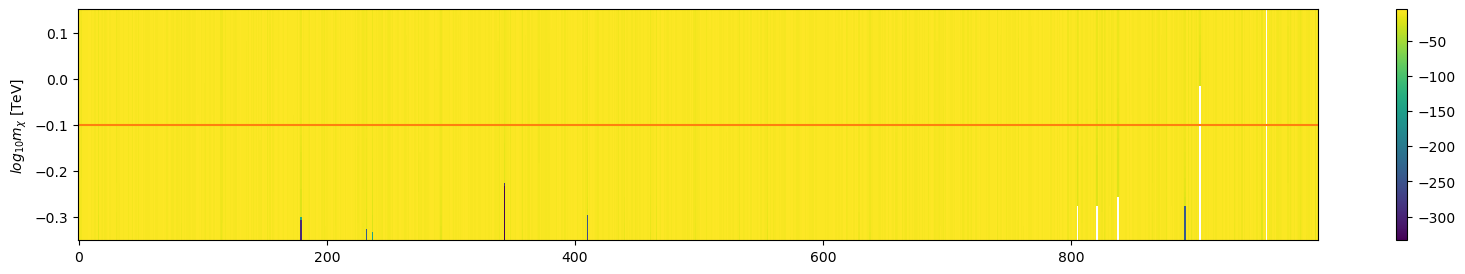

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(config_inputs['Nevents'])), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis')
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(config_inputs['logmass'], c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [ ]:
nbins_xi = 161
lambdawindowwidth      = 9/np.sqrt(config_inputs['Nevents'])


lambdalowerbound       = config_inputs['xi']-lambdawindowwidth
lambdaupperbound       = config_inputs['xi']+lambdawindowwidth




if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbins_xi) 

original_log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    original_log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

original_log_posterior = np.array(original_log_posterior)-special.logsumexp(original_log_posterior)
new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_posterior(
    mixture_axes=(lambdarange, 1-lambdarange), log_margresults=margresultsarray)

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 161/161 [00:00<00:00, 375.53it/s]


Reshaped mixture shape: (2, 1000)
reshaped_log_margresults[0,:]: [array([-7.10543749, -7.10511211, -7.10488026, -7.10598553, -7.10560282,
        -7.10519752, -7.10483607, -7.10564071, -7.10527733, -7.10514165,
        -7.10509299, -7.10602575, -7.10577329, -7.10549942, -7.10515794,
        -7.10569237, -7.10532094, -7.10507937, -7.10489488, -7.10561426,
        -7.10530723, -7.10503853, -7.10480227, -7.10453751, -7.10501734,
        -7.1049213 , -7.10487898, -7.10490302, -7.10550843, -7.10535195,
        -7.1051889 , -7.1050207 , -7.10550092, -7.10553349, -7.10563737,
        -7.1057995 , -7.10646915, -7.10641614, -7.10638137, -7.10637709,
        -7.1064047 , -7.1072438 , -7.10757934, -7.1079644 , -7.10827207,
        -7.10906885, -7.10932039, -7.10960464, -7.10992023, -7.11093709,
        -7.11139213, -7.11188231, -7.11231143, -7.11320963, -7.11359049,
        -7.11400847, -7.11445908, -7.11563916, -7.11640053, -7.11720201,
        -7.11795091, -7.11863272, -7.11981557, -7.12054248,

In [ ]:
log_posterior=np.squeeze(new_log_posterior)
# log_posterior = original_log_posterior

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_44978/3656591175.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.004788923537605237
0.0031606895348194556
0.0015324555320336748
0.0014366770612815724
0.0027775756518110353
0.004022695771588399


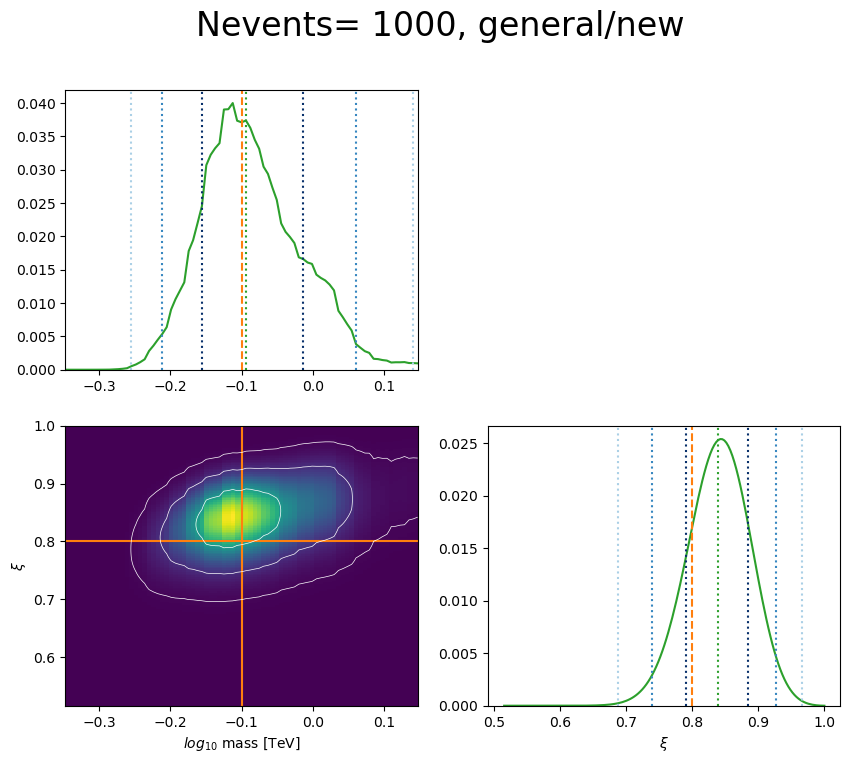

In [ ]:
from gammabayes.utils.utils import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {config_inputs['Nevents']}, general/new", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(config_inputs['logmass'], ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(config_inputs['logmass'], c='tab:orange')
ax[1,0].axhline(config_inputs['xi'], c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(config_inputs['xi'], ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{config_inputs['logmass']}_l{config_inputs['xi']}_%m%d_%H%M.pdf"))
plt.show()

In [ ]:
10/15

0.6666666666666666

In [ ]:
os.system('say Your code is finished.')


0

In [ ]:
# from utils3d import setup_full_fake_signal_dist, diff_irf_marg


# if __name__=="__main__":
#     nuisance_loge_setup_mesh, nuisance_longitude_setup_mesh, nuisance_latitude_setup_mesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

#     originalmethod_signal_prior_matrices = []
#     for logmass in logmassrange:
#         originalmethod_priorvals= setup_full_fake_signal_dist(logmass, specfunc=signalspecfunc)(nuisance_loge_setup_mesh, nuisance_longitude_setup_mesh, nuisance_latitude_setup_mesh)
        
#         originalmethod_priorvals = originalmethod_priorvals - special.logsumexp(logjacobtrue+originalmethod_priorvals)
#         originalmethod_signal_prior_matrices.append(originalmethod_priorvals.T)
    
    
#     originalmethod_marg_partial = functools.partial(diff_irf_marg, signal_prior_matrices=originalmethod_signal_prior_matrices, logbkgpriorvalues=logbkgpriorvalues, 
#                                                     logmassrange=logmassrange, edispnormvalues=edispnormalisationvalues, psfnormvalues=psfnormalisationvalues)

#     with Pool(config_inputs['numcores']) as pool:
#             originalmethod_margresults = pool.map(originalmethod_marg_partial, tqdm(zip(measured_log10e, measured_lon, measured_lat), total=len(list(measured_log10e))))

In [ ]:
originalmethod_margresultsarray = np.array(originalmethod_margresults)
originalmethod_sigmargresults = np.squeeze(np.vstack(originalmethod_margresultsarray[:,0])).T
originalmethod_bkgmargresults = np.squeeze(np.vstack(originalmethod_margresultsarray[:,1]))
originalmethod_sigmargresults.shape

NameError: name 'originalmethod_margresults' is not defined

In [ ]:

nbinslambda            = 161
lambdawindowwidth      = 9/np.sqrt(config_inputs['Nevents'])


lambdalowerbound       = config_inputs['xi']-lambdawindowwidth
lambdaupperbound       = config_inputs['xi']+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 

originalmethod_log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    originalmethod_log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

originalmethod_log_posterior = np.array(originalmethod_log_posterior)-special.logsumexp(originalmethod_log_posterior)


endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 81/81 [00:00<00:00, 925.49it/s]

232.51998933299998


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_39657/3766419917.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.005363594362117862
0.003448024947075767
0.0017240124735378834
0.0017240124735378869
0.0032564680055715617
0.0042142527130926075


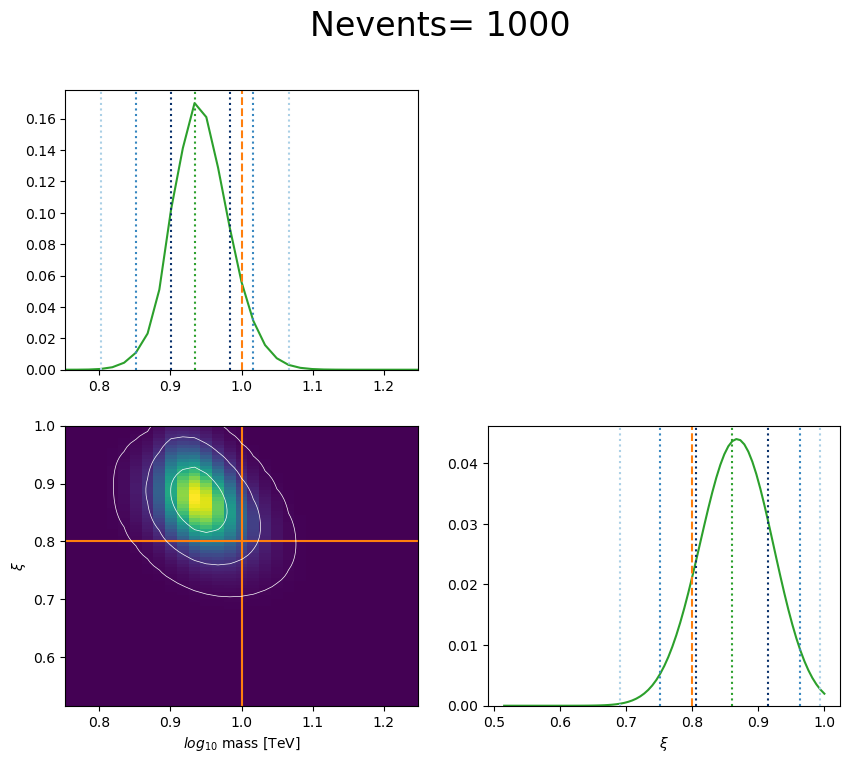

In [ ]:
from utils3d import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {config_inputs['Nevents']}", size=24)

# Upper left plot
originalmethod_logmass_logposterior = special.logsumexp(originalmethod_log_posterior, axis=0)

originalmethod_normalisedlogmassposterior = np.exp(originalmethod_logmass_logposterior-special.logsumexp(originalmethod_logmass_logposterior))

originalmethod_cdflogmassposterior = np.cumsum(originalmethod_normalisedlogmassposterior)
originalmethod_mean = logmassrange[np.abs(norm.cdf(0)-originalmethod_cdflogmassposterior).argmin()]
originalmethod_zscores = [-3, -2,-1,1,2, 3]
originalmethod_logmasspercentiles = []
for zscore in originalmethod_zscores:
    originalmethod_logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-originalmethod_cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,originalmethod_normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(originalmethod_mean, c='tab:green', ls=':')


for o, percentile in enumerate(originalmethod_logmasspercentiles):
            color = colormap(np.abs(originalmethod_zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(config_inputs['logmass'], ls='--', color="tab:orange")



ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(originalmethod_log_posterior), vmin=0)
ax[1,0].axvline(config_inputs['logmass'], c='tab:orange')
ax[1,0].axhline(config_inputs['xi'], c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
originalmethod_normed_posterior = np.exp(originalmethod_log_posterior)/np.exp(originalmethod_log_posterior).sum()
n = 100000
originalmethod_t = np.linspace(0, originalmethod_normed_posterior.max(), n)
originalmethod_integral = ((originalmethod_normed_posterior >= originalmethod_t[:, None, None]) * originalmethod_normed_posterior).sum(axis=(1,2))

from scipy import interpolate
originalmethod_f = interpolate.interp1d(originalmethod_integral, originalmethod_t)
originalmethod_t_contours = originalmethod_f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(originalmethod_normed_posterior, originalmethod_t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


originalmethod_lambda_logposterior = special.logsumexp(originalmethod_log_posterior, axis=1)

originalmethod_normalisedlambdaposterior = np.exp(originalmethod_lambda_logposterior-special.logsumexp(originalmethod_lambda_logposterior))

originalmethod_cdflambdaposterior = np.cumsum(originalmethod_normalisedlambdaposterior)
originalmethod_meanlambda = lambdarange[np.abs(norm.cdf(0)-originalmethod_cdflambdaposterior).argmin()]
originalmethod_lambdapercentiles = []
for zscore in originalmethod_zscores:
    originalmethod_lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-originalmethod_cdflambdaposterior).argmin()]
    originalmethod_lambdapercentiles.append(originalmethod_lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(originalmethod_lambdapercentile - originalmethod_meanlambda))





ax[1,1].plot(lambdarange,originalmethod_normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(originalmethod_meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(originalmethod_lambdapercentiles):
            color = colormap(np.abs(originalmethod_zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(config_inputs['xi'], ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{config_inputs['logmass']}_l{config_inputs['xi']}_%m%d_%H%M.pdf"))
plt.show()